# **IMAGE CLASSIFICATOR WITH PSO FOR HYPERPARAMETERS OPTIMIZATION**

In [64]:
# %pip install nbformat

%run PSO.ipynb #da qui possiamousare la funzione PSO

## Definition of the problem and main goal
In this notebook we want to write a Convolutional Neural Network (CNN) with the aim of classify the images taken by the **CIFAR-10** dataset. Moreover we want to use **Particle Swarm Optimization** (PSO) in order to optimize some characteristics of the CNN concerning architecture and hyperparameters. The PSO has been implemented by us by using a class called **particle**

## CIFAR-10 dataset preprocessing
Quoting directly the official webpage (https://www.cs.toronto.edu/~kriz/cifar.html):
"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into training and test. The test batch contains exactly 1000 randomly-selected images from each class. The train dataset contains the remaining images in random order. The train dataset contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

<img src="Immagine 2023-02-08 183815.png" alt="drawing" width="50%" height="40%"/>

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks."

All code related to image preprocessing and model creation is taken from https://www.kaggle.com/code/vortexkol/alexnet-cnn-architecture-on-tensorflow-beginner#Dataset

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

First we load the data and we define train, validation and test sample datasets which will be used to testing the code.

In [66]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

#train sample is composed by 1000 images
train_sample = X_train[:1000]
train_sample_labels = y_train[:1000]

#test sample is composed by 200 images
test_sample = X_test[:200]
test_sample_labels = y_test[:200]

#validation sample is composed by 250 images
valid_sample = X_train[1000:1250]
valid_sample_labels = y_train[1000:1250]

Below are showed some images from the train and test dataset

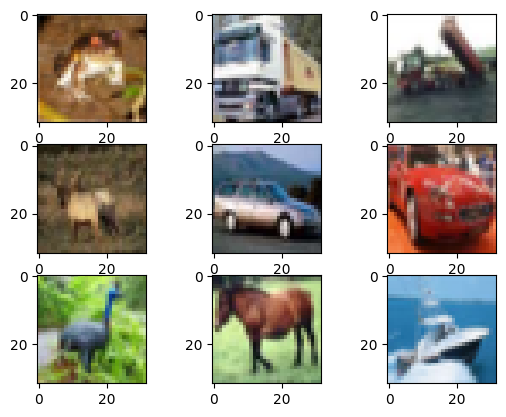

In [67]:
for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(X_train[i])
plt.show()

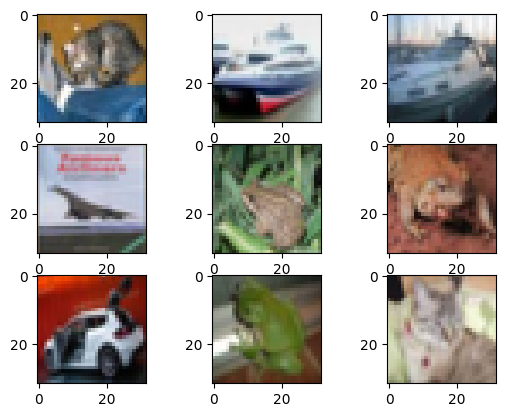

In [68]:
for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(X_test[i])
plt.show()

Noe let's see how are represented the labels of the classes

In [69]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [74]:
print('Train classes',np.unique(y_train))
print('Test classes',np.unique(y_test))

Train classes [0 1 2 3 4 5 6 7 8 9]
Test classes [0 1 2 3 4 5 6 7 8 9]


Now we create three datatset in which at each image corresponds the relativa label

In [59]:
train_ds=tf.data.Dataset.from_tensor_slices((train_sample,train_sample_labels))
valid_ds=tf.data.Dataset.from_tensor_slices((valid_sample,valid_sample_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_sample,test_sample_labels))

We preprocess the image by standardizing and resizing them because the original dimension of the images is 32x32x3, but to apply the alexnet we want 64x64x3.

In [60]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    
    return image,label

### **CNN - AlexNet**

Let's build the AlexNet Neural Network architecture which is composed by 5 convolutional layers and 3 fully connected layer.

In [61]:
model=keras.models.Sequential([

    #1st convolutional layer
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),

    #2nd convolutional layer
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),

    #3rd convolutional layer
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    #4th convolutional layer
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    #5th convolutional layer
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),

    #Flattening
    keras.layers.Flatten(),

    #1st Dense layer
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),

    #2nd Dense layer
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),

    #3rd Dense layer (outuput with softmax)
    keras.layers.Dense(10,activation='softmax')  
    ])

In [62]:
# mi serve una funzione che prenda in input solo i parametri della pso e restituisca l'accuracy

def CNN(particle_position, train_ds = train_ds, valid_ds = valid_ds, model = model):
    '''This function returns the accuracy of a neural network model with the parameter set as the component of the particle position.
     The first component of the position will be the batch size, the second willl be the optimizer and the third will be the learning rate. 
     particle_position[0]: batch_size
     particle_position[1]: optimizer (<1: SGD; within [1,2): SGD with Momentum; within [2,3): Adam; within [3,inf]: RMSPROP )
     particle_position[2]: learning_rate
     '''


    batch_size = particle_position[0]
    optimizer = particle_position[1]
    learning_rate = particle_position[2]

    print(batch_size, optimizer, learning_rate)
    
    train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
    valid_ds_size=tf.data.experimental.cardinality(valid_ds).numpy()

    train_ds = (train_ds.map(process_image).shuffle(buffer_size = train_ds_size).batch(batch_size=int(batch_size), drop_remainder = True))
    valid_ds = (valid_ds.map(process_image).shuffle(buffer_size = valid_ds_size).batch(batch_size=int(batch_size), drop_remainder = True))

    if optimizer < 1:
        #use SGD
        opt = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate)
        
    elif optimizer >=1 and optimizer < 2:
        #use SGD with Momentum
        opt = tf.keras.optimizers.experimental.SGD(momentum = 0.9, learning_rate = learning_rate)

    elif optimizer >= 2 and optimizer < 3:
        #use ADAM
        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    else:
        #use RMSPROP
        opt = tf.keras.optimizers.experimental.RMSprop(learning_rate = learning_rate)

    model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= opt,
    metrics=['accuracy'])

    # print(model.summary())

    history=model.fit(
    train_ds,
    epochs=5,
    validation_data=valid_ds,
    validation_freq=1)

    last_accuracy = history.history['val_accuracy'][-1]

    return last_accuracy


In [63]:
# Nella funzione CNN la prima componente è il batch_size, che varia tra 0 e 128.
# La seconda componente è l'optimizer che varia tra 0 e 4. (tra 0 e 1 usa sgd, tra 1 e 2 usa sgd with momenutm, tra 2 e 3 usa adam e tra 3 e 4 usa rmsprop).
# La terza componente il learning rate che varia tra 0.001 e 0.01

best_positions, best_parameter, best_accuracy = PSO(swarm_size = 10,
                                    dim = 3,
                                    evaluation_funct = CNN,
                                    lower_bound=[0,0,0.0001],
                                    upper_bound = [128,4,0.01],
                                    v_max = [64,2,0.001],
                                    problem = 'maximum',
                                    max_iteration = 2,
                                    termination_criteria = ['fixed_iteration', 'swarm_radius'],
                                    max_tol = 0.1)

print('Best position found: ', best_parameter, 'with an accuracy of: ',best_accuracy)

14.929014880392245 3.994919177538065 0.00304814772310723
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 14, 14, 128)       46592     
                                                                 
 batch_normalization_35 (Bat  (None, 14, 14, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 7, 7, 256)         819456    
                                                                 
 batch_normalization_36 (Bat  (None, 7, 7, 256)        1024      
 chNormalization)                                              

After having found the best parameter combination with PSO, we can use the model to predict the classes for the testing data set.